# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [52]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [53]:
pip show pandas | grep Version

Version: 2.2.1
Note: you may need to restart the kernel to use updated packages.


In [54]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%reload_ext autoreload

In [56]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [57]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Thursday March 7th

In [91]:
synch_times = {}

In [92]:
cue_times = pd.read_csv('./outfiles/cue1_20240307.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240307'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

21.609342    0.0000
23.719456    2.1102
25.611882    4.0026
27.492698    5.8834
Name: SyncTime, dtype: float64

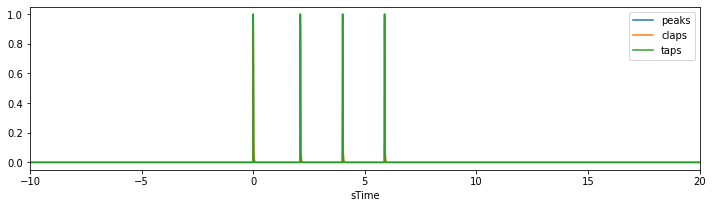

In [93]:
CueT={}
sf = 256
t_range= [-10,20]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240307'] = cue

In [94]:
cue_times = pd.read_csv('./outfiles/cue2_20240307.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue2_20240307'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

19081.387417    19059.7781
19083.007009    19061.3977
19084.664333    19063.0550
19086.565467    19064.9562
Name: SyncTime, dtype: float64

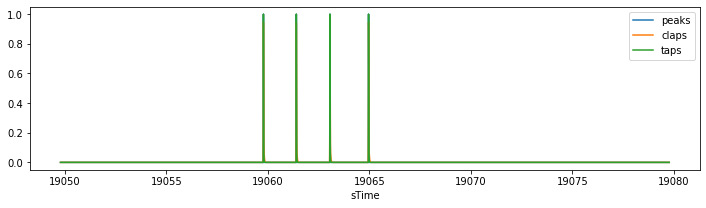

In [95]:
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue2_20240307'] = cue

In [96]:
synch_times

{'cue1_20240307': Timestamp('2024-03-07 06:57:50.609342404'),
 'cue2_20240307': Timestamp('2024-03-07 12:15:30.387417234')}

In [97]:
cue

,sTime,peaks,taps,claps
0,19049.778100,0,0.000000e+00,0.0
1,19049.782006,0,0.000000e+00,0.0
2,19049.785912,0,0.000000e+00,0.0
3,19049.789819,0,0.000000e+00,0.0
4,19049.793725,0,0.000000e+00,0.0
...,...,...,...,...
7675,19079.758569,0,9.881313e-324,0.0
7676,19079.762475,0,9.881313e-324,0.0
7677,19079.766381,0,9.881313e-324,0.0
7678,19079.770287,0,0.000000e+00,0.0


## Load example of ACC data

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [98]:
data_dir='/Volumes/Seagatehub/BiC2024/20240307/Equivital/Extracted SEM Data/'
# data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             3420415
Date                                                            240307
Session                                                              0
FileName                               DATA-VN101-3420415-24030700.CSV
FileType                                                           csv
FileSize                                                        113066
RecStart                                     2024-03-07 06:49:41+00:00
RecEnd                                       2024-03-07 12:20:56+00:00
Duration                                                       19875.0
BatteryStart                                                      4129
BatteryEnd                                                        4000
BatteryChange(mV)                                                 -129
FullLoc              /Volumes/Seagatehub/BiC2024/20240307/Equivital...
DATAlo

In [99]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-07 06:49:13.007,0.0
1,2024-03-07 06:49:13.011,0.0
2,2024-03-07 06:49:13.015,0.0
3,2024-03-07 06:49:13.019,0.0
4,2024-03-07 06:49:13.023,0.0
5,2024-03-07 06:49:13.027,0.0


In [100]:
c = 'cue1_20240307'
synch_times[c]

Timestamp('2024-03-07 06:57:50.609342404')

15360


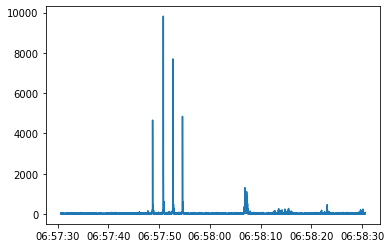

In [101]:
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [105]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240307'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(0,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-07 06:57:50.609342404


,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [106]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

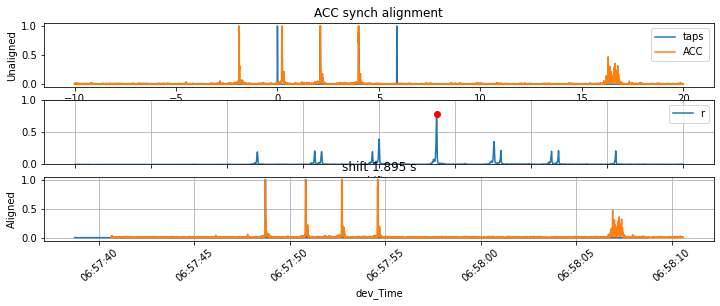

2024-03-07 06:57:48.714811154


In [107]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

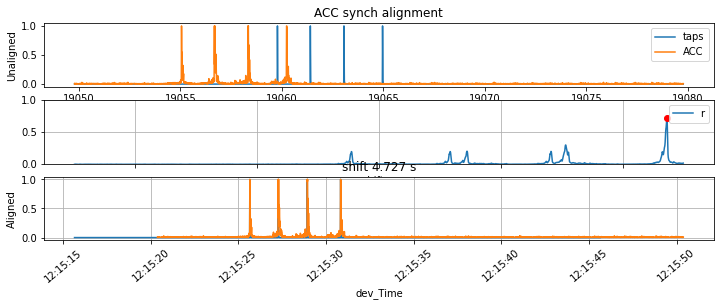

Timestamp('2024-03-07 12:15:25.660879904')

In [108]:
c = 'cue2_20240307'
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(20,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
results = min_align(ACC_ex,CueT[c].copy(),synch_times['cue1_20240307'].tz_localize(None),10)
results['best_dt']

In [109]:
results

{'best_dt': Timestamp('2024-03-07 12:15:25.660879904'),
 'best_s': 4.7265625,
 'best_r': 0.7088463358151099,
 'CCC':        shift_s         r
 0    -5.000000 -0.009286
 1    -4.996094 -0.008352
 2    -4.992188 -0.007350
 3    -4.988281 -0.006853
 4    -4.984375 -0.007133
 ...        ...       ...
 2555  4.980469  0.006432
 2556  4.984375  0.006598
 2557  4.988281  0.007596
 2558  4.992188  0.008223
 2559  4.996094  0.009400
 
 [2560 rows x 2 columns],
 'cue':              sTime  peaks           taps  claps                         dTime  \
 0     19049.778100      0   0.000000e+00    0.0 2024-03-07 12:15:20.387442404   
 1     19049.782006      0   0.000000e+00    0.0 2024-03-07 12:15:20.391348654   
 2     19049.785912      0   0.000000e+00    0.0 2024-03-07 12:15:20.395254904   
 3     19049.789819      0   0.000000e+00    0.0 2024-03-07 12:15:20.399161154   
 4     19049.793725      0   0.000000e+00    0.0 2024-03-07 12:15:20.403067404   
 ...            ...    ...            ...    

# Running through the sensors

In [110]:
#data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
data_dir='/Volumes/Seagatehub/BiC2024/20240307/Equivital/Extracted SEM Data/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240307,0,DATA-VN101-3420415-24030700.CSV,csv,113066,2024-03-07 06:49:41+00:00,2024-03-07 12:20:56+00:00,19875.0,...,[VN101],3420415.0,VN101,53.0,0,98.0,0.0,0.0,MovingSlowly,Upright
VN104,DATA,3420456,240307,101,DATA-VN104-3420456-24030700_0.CSV,csv,112528,2024-03-07 06:49:43+00:00,2024-03-07 12:22:43+00:00,19980.0,...,[VN104],3420456.0,VN104,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN109,DATA,5022010,240307,101,DATA-VN109-5022010-24030700_0.CSV,csv,112208,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,[VN109],5022010.0,VN109,53.0,79,98.0,0.0,0.0,Stationary,Upright
VN105,DATA,3420755,240307,101,DATA-VN105-3420755-24030700_0.CSV,csv,111795,2024-03-07 06:49:45+00:00,2024-03-07 12:21:15+00:00,19890.0,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240307,0,DATA-VN111-5022027-24030700.CSV,csv,112517,2024-03-07 06:49:49+00:00,2024-03-07 12:22:04+00:00,19935.0,...,[VN111],5022027.0,VN111,53.0,2,97.0,0.0,0.0,Stationary,Upright


['VN101', 18.142011880874634]


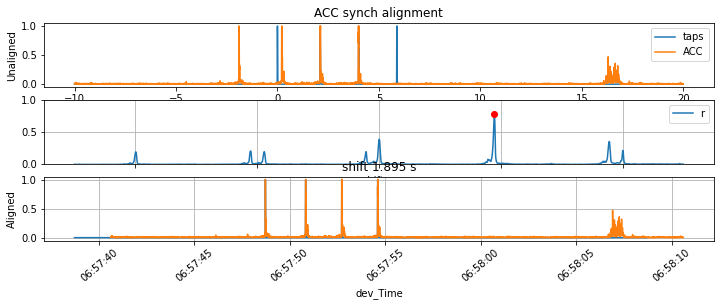

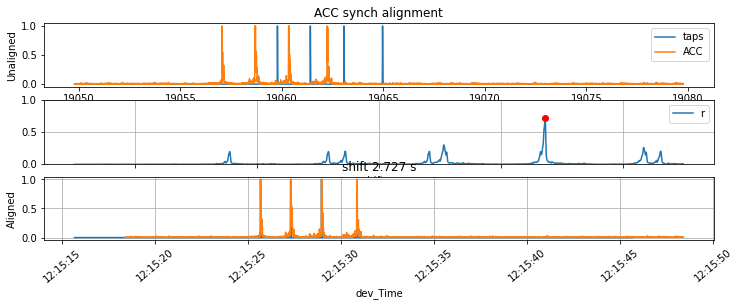

['VN104', 39.723997831344604]


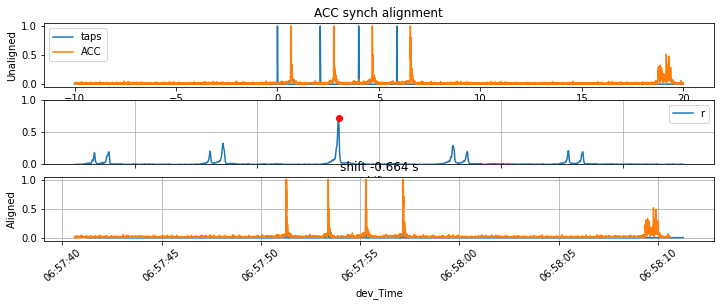

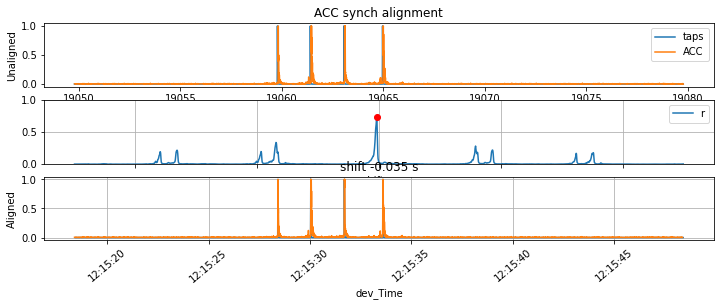

['VN109', 60.67922377586365]


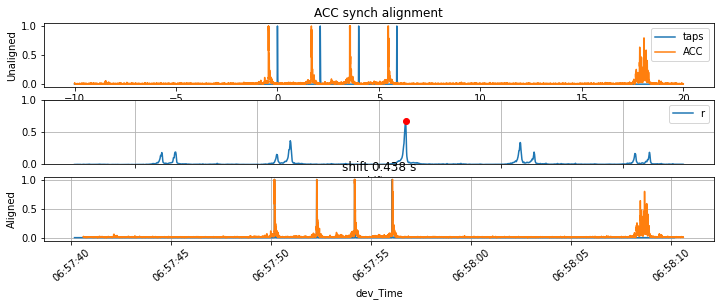

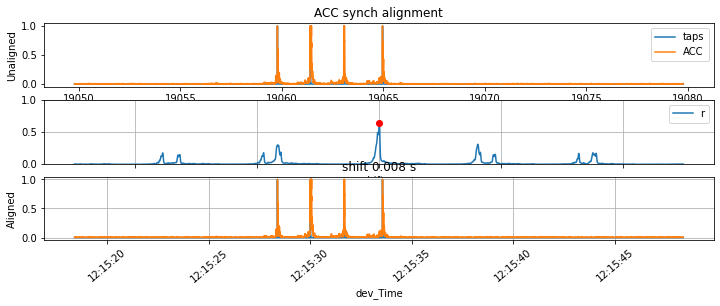

['VN105', 82.44343781471252]


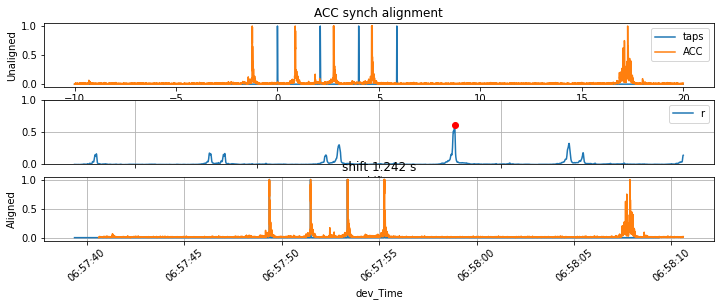

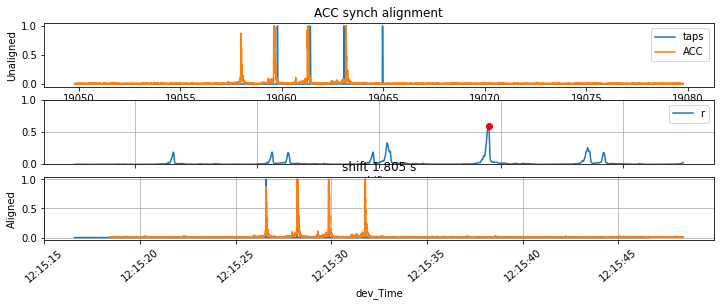

['VN111', 103.86482787132263]


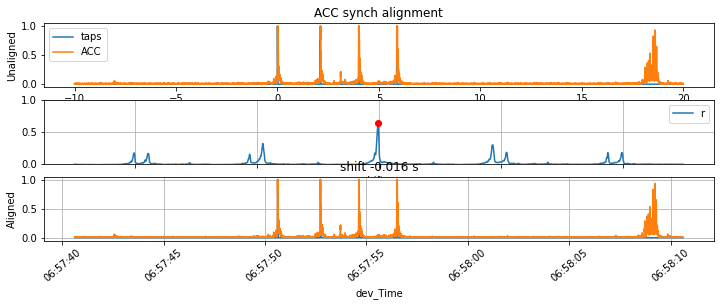

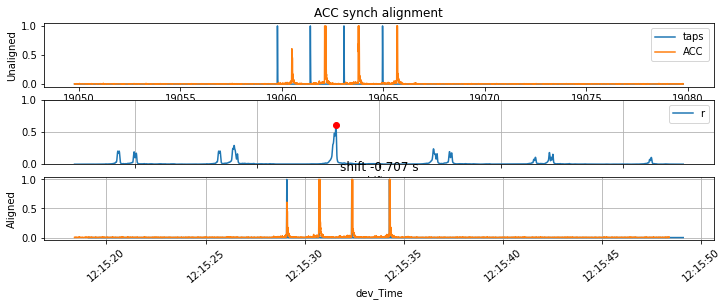

['VN110', 125.31972885131836]


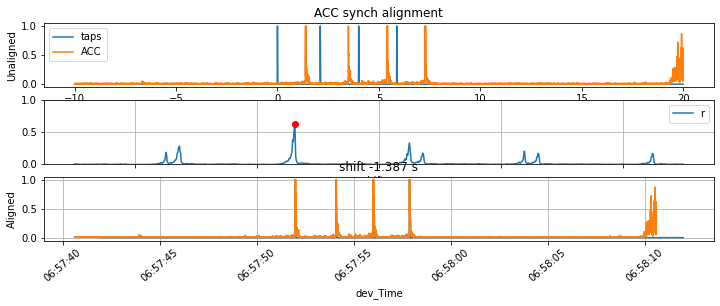

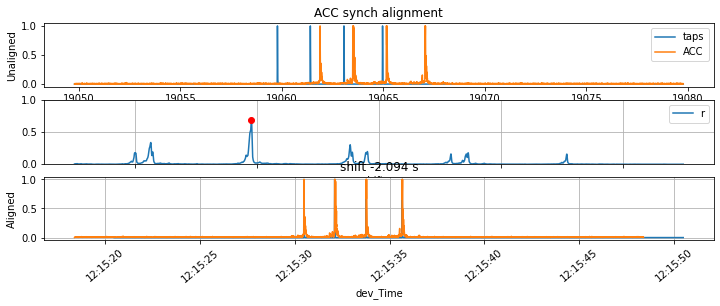

['VN201', 146.94118690490723]


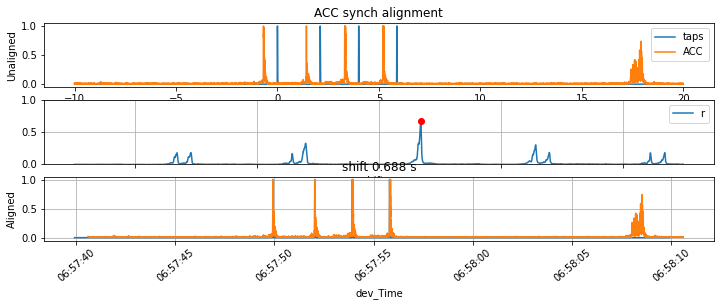

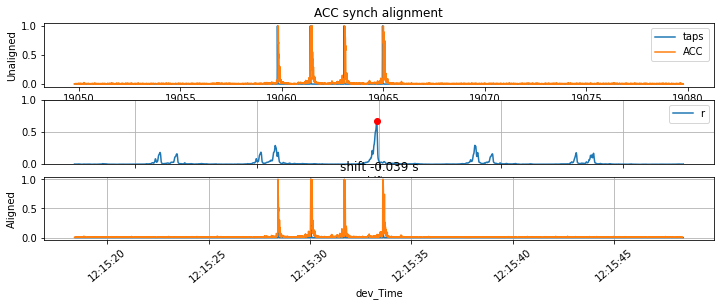

['VN206', 168.02046990394592]


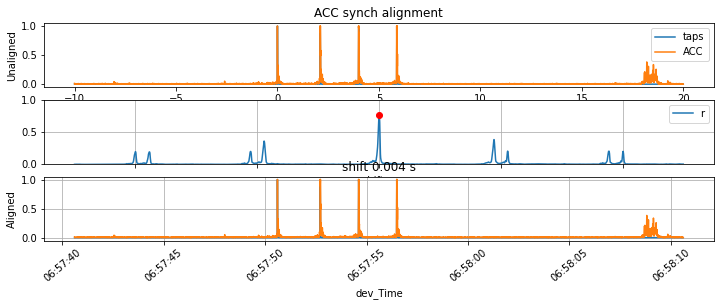

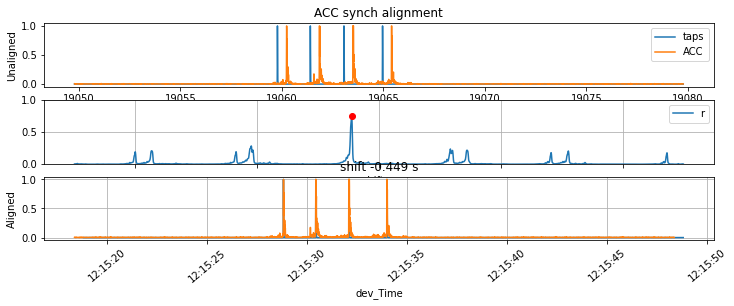

['VN211', 189.5472867488861]


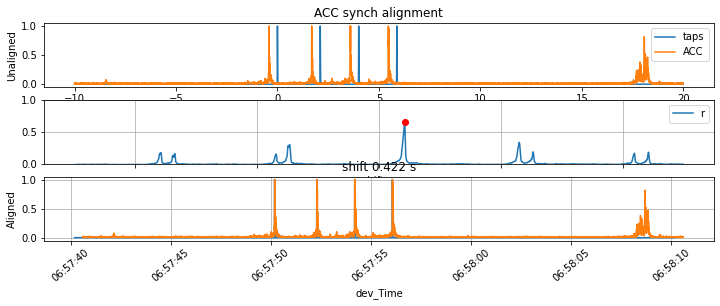

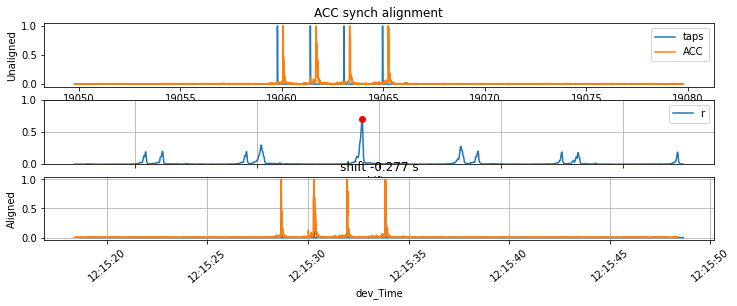

['VN212', 210.99878406524658]


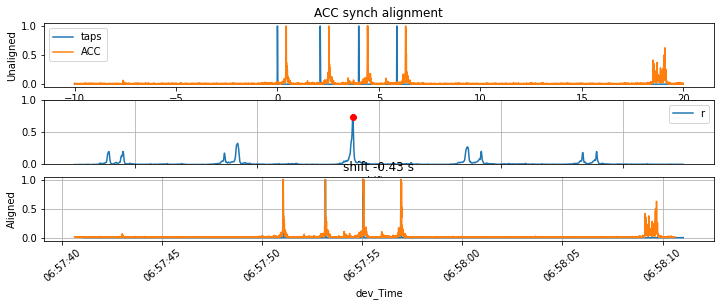

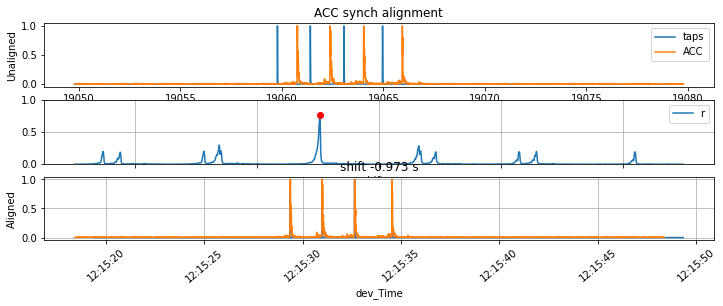

['VA304', 232.41218209266663]


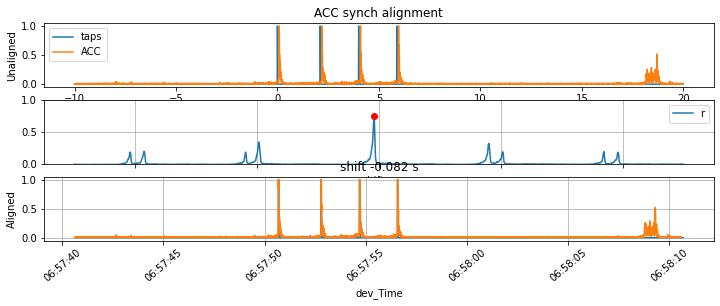

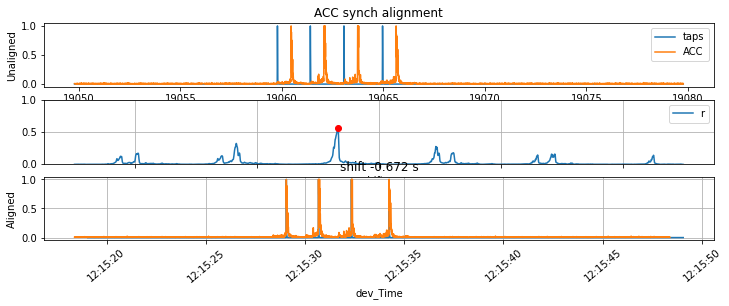

['VA305', 254.4678647518158]


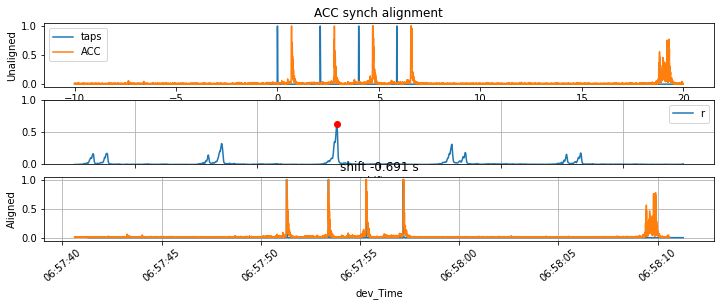

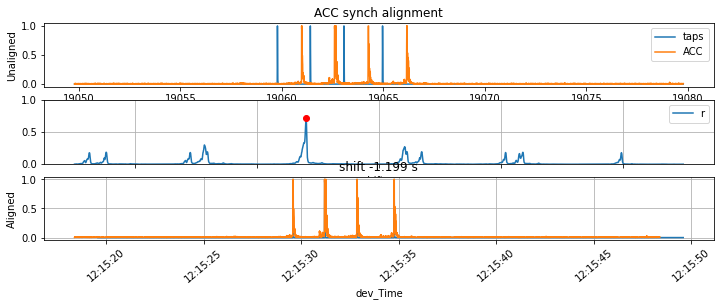

['VA309', 275.78969502449036]


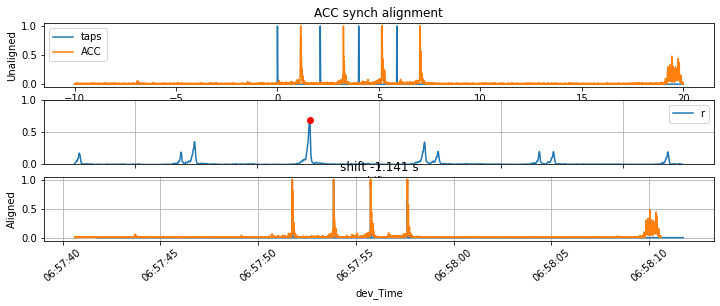

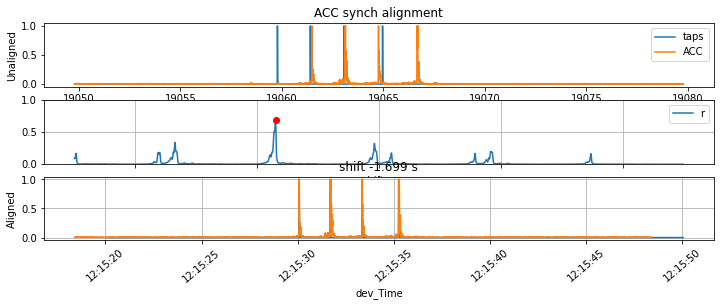

['LS401', 297.04277205467224]


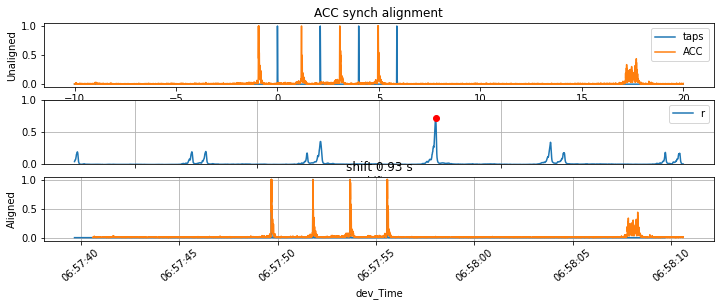

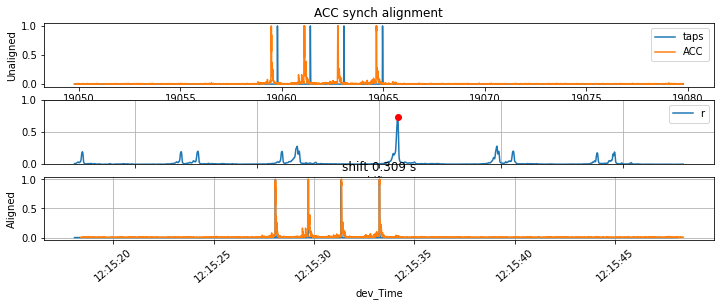

['LS404', 318.5198128223419]


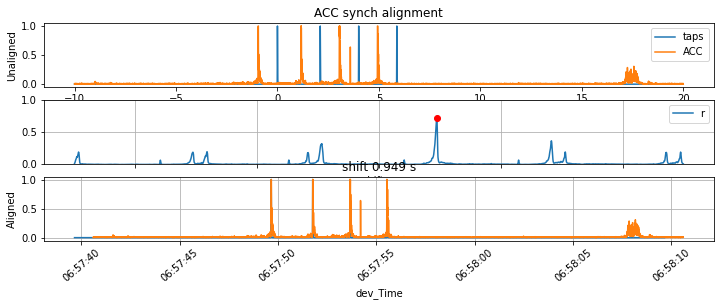

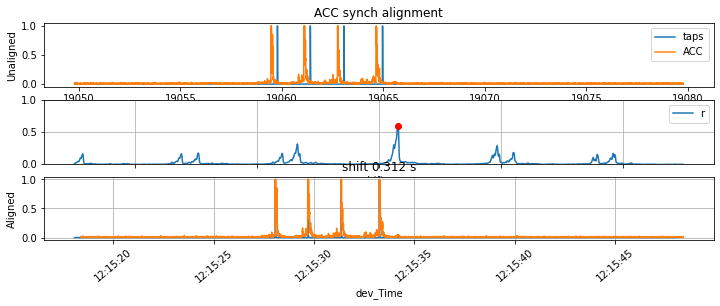

['LS405', 339.5268449783325]


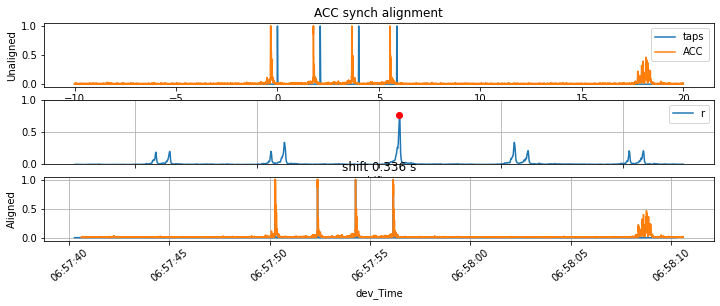

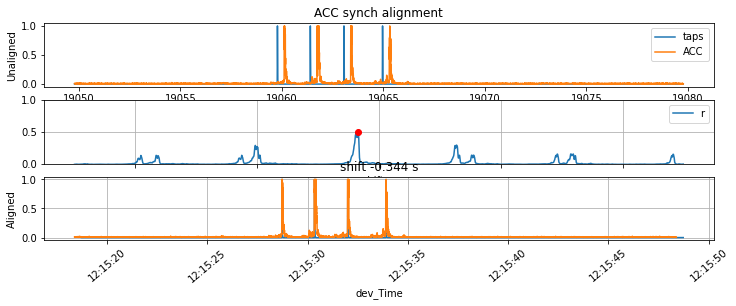

['LS407', 360.37197279930115]


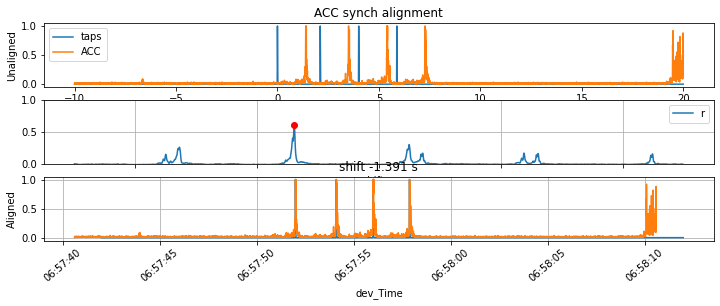

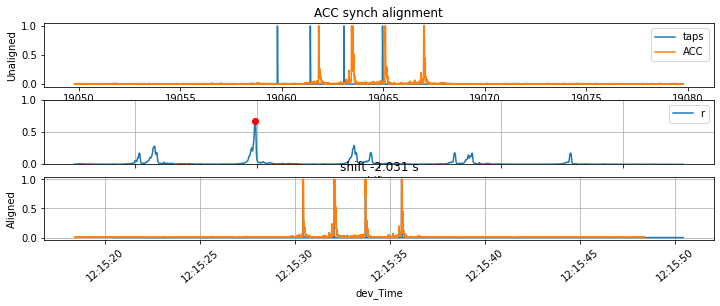

['LS409', 381.9087209701538]


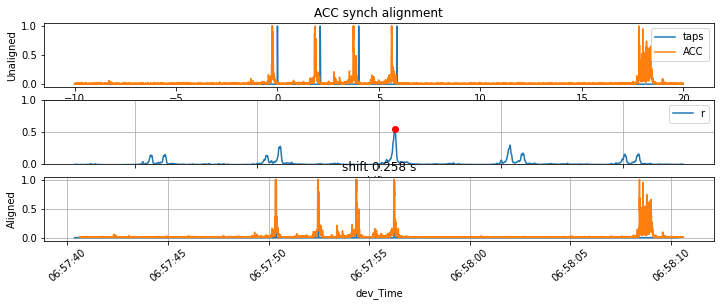

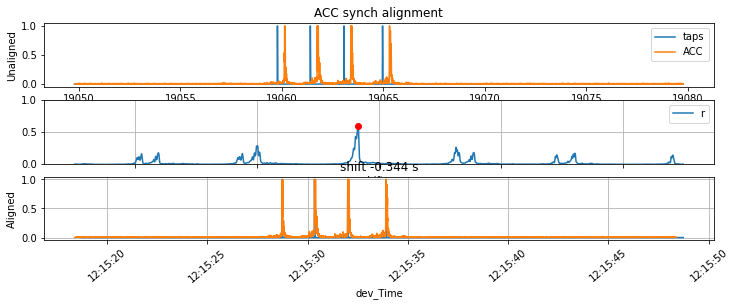

['BR608', 402.73804092407227]


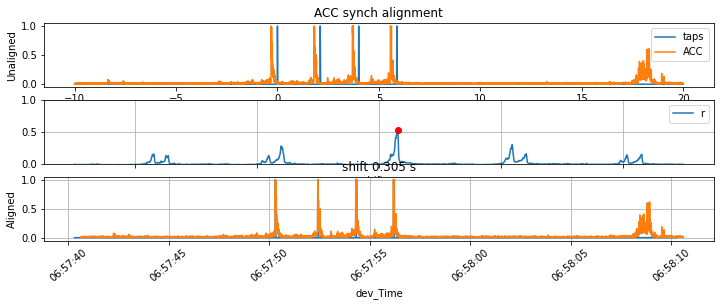

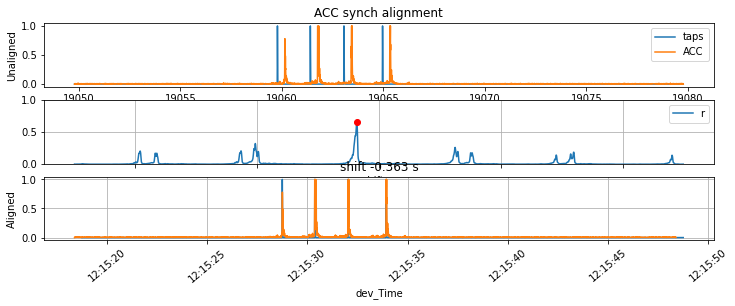

['BR606', 423.11090779304504]


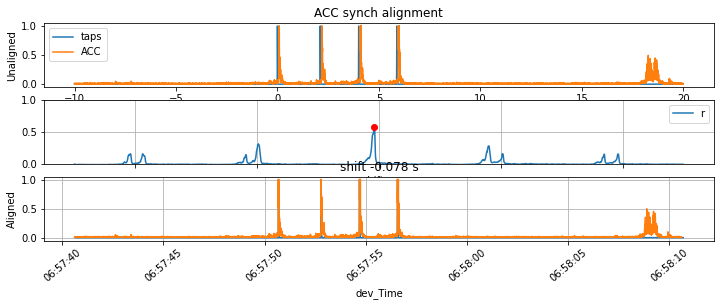

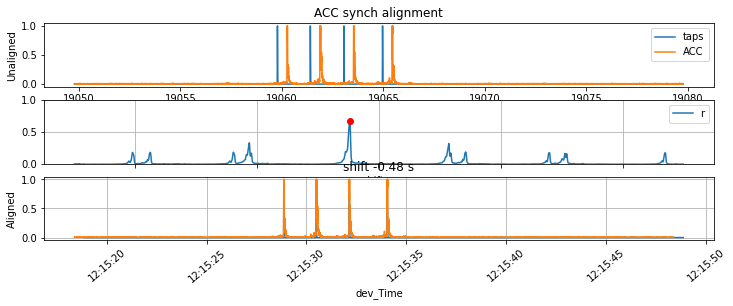

['PC702', 443.19204473495483]


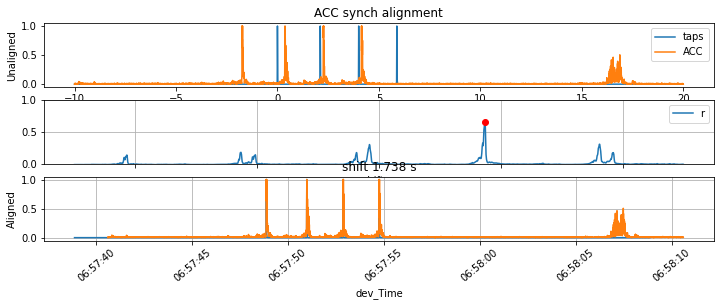

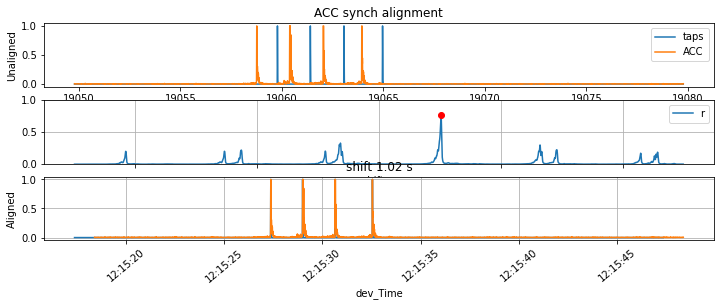

['BR609', 463.2450807094574]


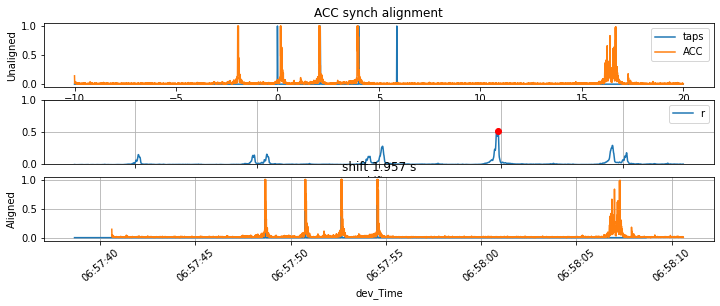

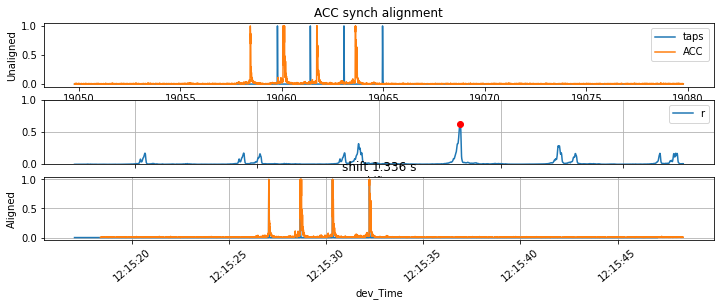

['PC709', 483.22830390930176]


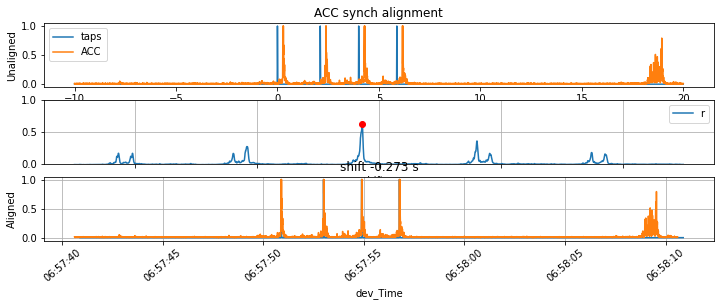

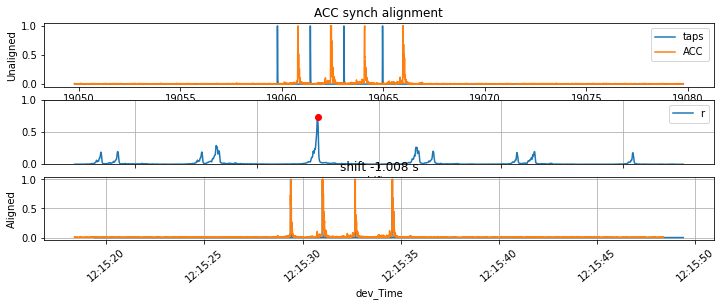

['PC710', 503.34915375709534]


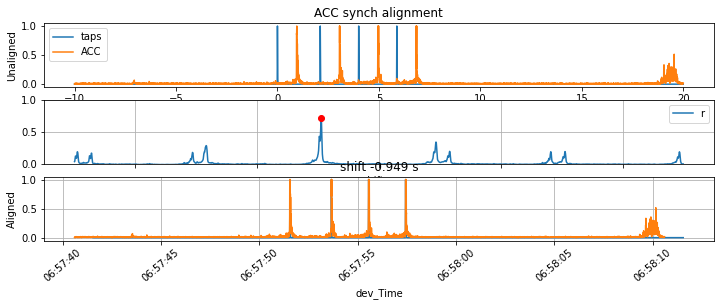

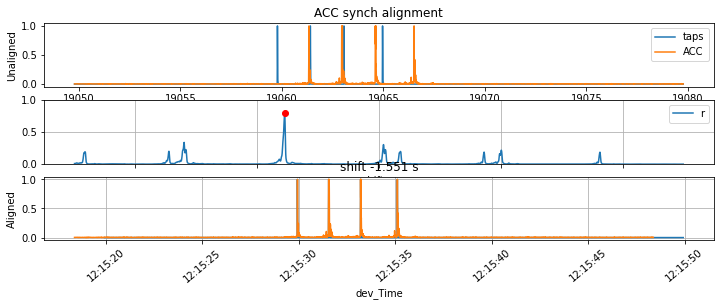

['WW504', 523.5008578300476]


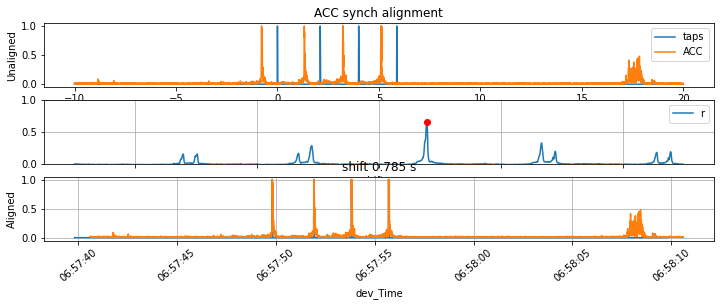

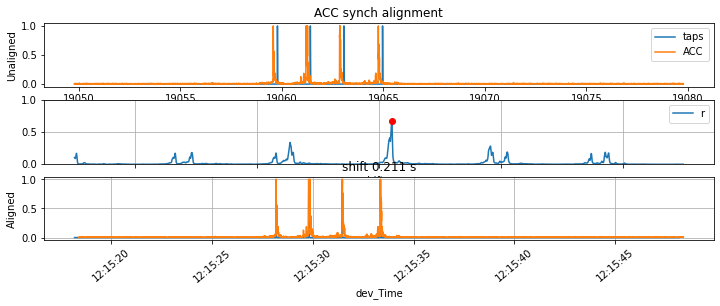

['LS410', 543.1155779361725]


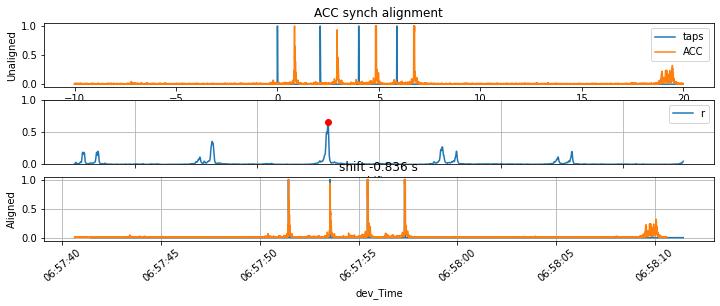

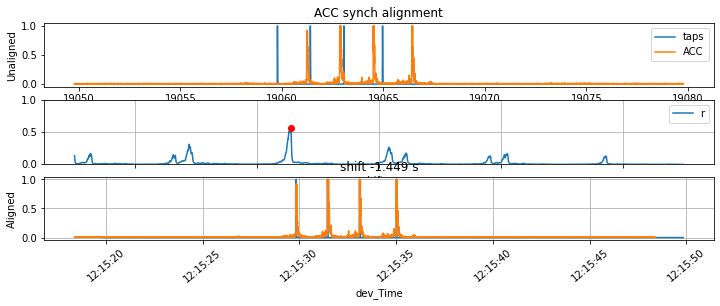

['WW506', 563.5528976917267]


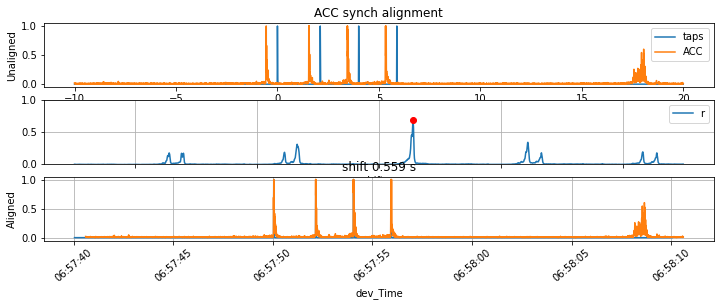

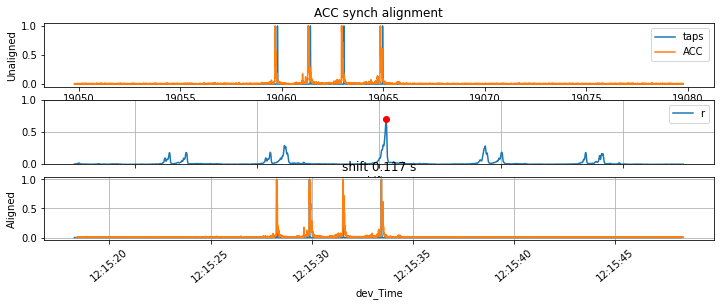

['WW508', 584.1401717662811]


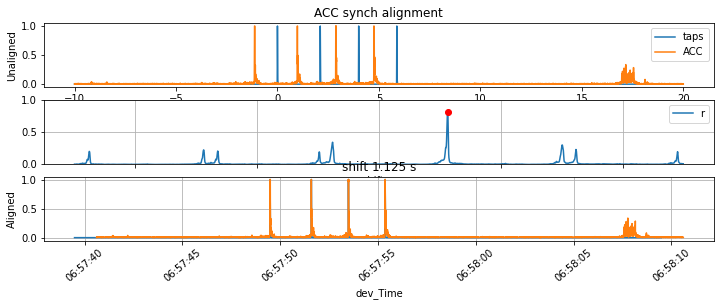

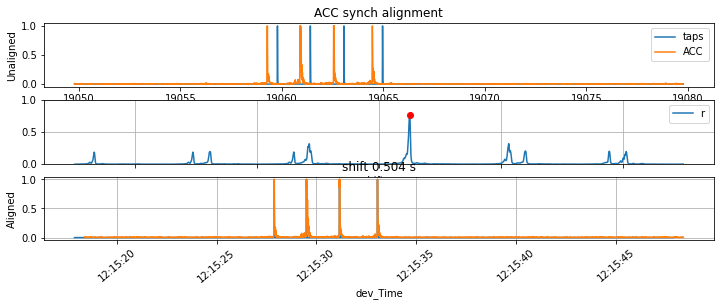

['BR604', 604.5541799068451]


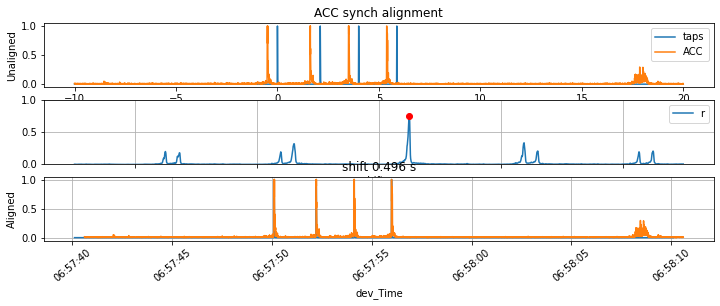

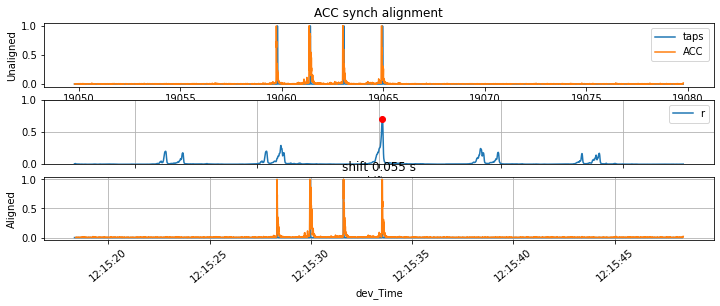

['BR605', 625.0189347267151]


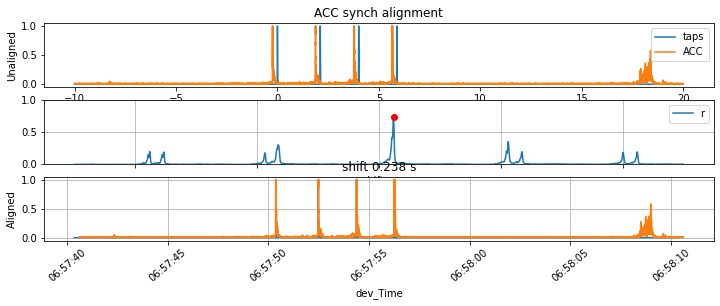

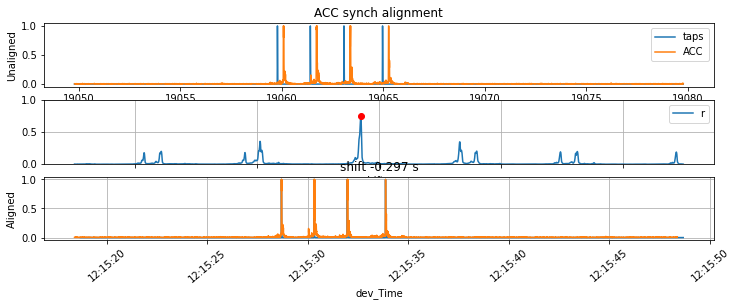

627.3606908321381


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r
DevName,,,,,,
VN101,2024-03-07 06:57:48.714811154,1.894531,0.771807,2024-03-07 12:15:25.660879904,4.726562,0.708769
VN104,2024-03-07 06:57:51.273404904,-0.664062,0.720048,2024-03-07 12:15:28.422598654,1.964844,0.730254
VN109,2024-03-07 06:57:50.171842404,0.4375,0.662459,2024-03-07 12:15:28.379629904,2.007812,0.639071
VN105,2024-03-07 06:57:49.367154904,1.242188,0.612933,2024-03-07 12:15:26.582754904,3.804688,0.595153
VN111,2024-03-07 06:57:50.624967404,-0.015625,0.644069,2024-03-07 12:15:29.094473654,1.292969,0.611731
VN110,2024-03-07 06:57:51.996061154,-1.386719,0.626103,2024-03-07 12:15:30.481192404,-0.09375,0.690122
VN201,2024-03-07 06:57:49.921842404,0.6875,0.664385,2024-03-07 12:15:28.426504904,1.960938,0.671248
VN206,2024-03-07 06:57:50.605436154,0.003906,0.765091,2024-03-07 12:15:28.836661154,1.550781,0.748492
VN211,2024-03-07 06:57:50.187467404,0.421875,0.659537,2024-03-07 12:15:28.664786154,1.722656,0.692505


In [111]:
df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = 0
t_drift = 2

for pid,row in df_datafiles.iterrows():
    V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
    ACC = pd.DataFrame()
    ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
    df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
    ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
    ACC = remove_tz_from_dataframe(ACC)
    print([pid,time.time()-tic])
    
    dt_0 = synch_times['cue1_20240307']-pd.to_timedelta(20,unit='s')
    dt_1 = synch_times['cue1_20240307']+pd.to_timedelta(20,unit='s')
    ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
    maxlag_s = 5
    results = min_align(ACC_ex,CueT['cue1_20240307'].copy(),(synch_times['cue1_20240307']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
    df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
    df_shifts.loc[pid,'Cue1_s'] = results['best_s']
    df_shifts.loc[pid,'Cue1_r'] = results['best_r']

    dt_0 = synch_times['cue2_20240307']-pd.to_timedelta(20,unit='s')
    dt_1 = synch_times['cue2_20240307']+pd.to_timedelta(20,unit='s')
    ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
    maxlag_s = 10
    results = min_align(ACC_ex,CueT['cue2_20240307'].copy(),(synch_times['cue1_20240307']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
    df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
    df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
    df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [119]:
[df_shifts['Cue1_s'].mean(),df_shifts['Cue2_s'].mean()]

[0.21419270833333334, 1.7463541666666667]

In [120]:
df_shifts['dur_dt']=pd.to_datetime(df_shifts['Cue2_devdTime'])-pd.to_datetime(df_shifts['Cue1_devdTime'])
df_shifts['dur_s']=df_shifts['dur_dt'].dt.total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')

In [117]:
(synch_times['cue2_20240307']-synch_times['cue1_20240307']).total_seconds()

19059.778074

In [114]:
# cues_delta = 19059.7765
cues_delta = (synch_times['cue2_20240307']-synch_times['cue1_20240307']).total_seconds()
df_shifts['drift_s'] = df_shifts['dur_s']-cues_delta 
df_shifts['drift_rate_sphr']=(df_shifts['drift_s'])/(cues_delta/3600)
# drifted seconds per hour
df_shifts['drift_rate_sphr']

DevName
VN101   -0.534908
VN104   -0.496541
VN109   -0.296595
VN105   -0.483999
VN111   -0.247162
VN110   -0.244210
VN201   -0.240521
VN206   -0.292168
VN211   -0.245686
VN212   -0.275198
VA304   -0.266345
VA305   -0.281839
VA309   -0.272247
LS401   -0.260442
LS404   -0.257491
LS405   -0.249375
LS407   -0.256753
LS409   -0.264131
BR608   -0.251588
BR606   -0.301759
PC702   -0.241997
BR609   -0.260442
PC709   -0.239046
PC710   -0.264131
WW504   -0.269296
LS410   -0.261918
WW506   -0.294381
WW508   -0.260442
BR604   -0.294381
BR605   -0.276674
Name: drift_rate_sphr, dtype: float64

In [115]:
df_shifts['devID'] = df_datafiles['ID']

In [118]:
df_shifts.to_csv('./outfiles/Cue_dev_align_20240307.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,drift_s,drift_rate_sphr,devID
DevName,,,,,,,,,,,
VN101,2024-03-07 06:57:48.714811154,1.894531,0.771807,2024-03-07 12:15:25.660879904,4.726562,0.708769,0 days 05:17:36.946068750,19056.946069,-2.832005,-0.534908,3420415
VN104,2024-03-07 06:57:51.273404904,-0.664062,0.720048,2024-03-07 12:15:28.422598654,1.964844,0.730254,0 days 05:17:37.149193750,19057.149194,-2.628880,-0.496541,3420456
VN109,2024-03-07 06:57:50.171842404,0.4375,0.662459,2024-03-07 12:15:28.379629904,2.007812,0.639071,0 days 05:17:38.207787500,19058.207787,-1.570287,-0.296595,5022010
VN105,2024-03-07 06:57:49.367154904,1.242188,0.612933,2024-03-07 12:15:26.582754904,3.804688,0.595153,0 days 05:17:37.215600,19057.215600,-2.562474,-0.483999,3420755
VN111,2024-03-07 06:57:50.624967404,-0.015625,0.644069,2024-03-07 12:15:29.094473654,1.292969,0.611731,0 days 05:17:38.469506250,19058.469506,-1.308568,-0.247162,5022027
VN110,2024-03-07 06:57:51.996061154,-1.386719,0.626103,2024-03-07 12:15:30.481192404,-0.09375,0.690122,0 days 05:17:38.485131250,19058.485131,-1.292943,-0.244210,5022026
VN201,2024-03-07 06:57:49.921842404,0.6875,0.664385,2024-03-07 12:15:28.426504904,1.960938,0.671248,0 days 05:17:38.504662500,19058.504662,-1.273412,-0.240521,5022050
VN206,2024-03-07 06:57:50.605436154,0.003906,0.765091,2024-03-07 12:15:28.836661154,1.550781,0.748492,0 days 05:17:38.231225,19058.231225,-1.546849,-0.292168,5022062
VN211,2024-03-07 06:57:50.187467404,0.421875,0.659537,2024-03-07 12:15:28.664786154,1.722656,0.692505,0 days 05:17:38.477318750,19058.477319,-1.300755,-0.245686,5022247
